In [1]:
import importlib
import numpy as np
import os, sys
os.environ["PYTHONPATH"] = "../"
sys.path.insert(0, "../")

from src.vllm.qwen import QwenVLProbe
import torch

from src.data.dataset_loader import DSLoader
from src.probes.classifier import build_classifier
from src.probes.trainer import Trainer, RunConfig
import torch
from torch.utils.data import DataLoader, TensorDataset

h:\Users\Jona\Dokumente\Evuloc\ULM_Probing_VLMs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds_loader = DSLoader(split="train")
ds = ds_loader.get_caption_ds()

In [3]:
ds_loader = DSLoader(split="train")
ds2 = ds_loader.get_category_ds()

In [ ]:
import src.vllm.qwen

device = "cpu"
model_name = "Qwen/Qwen2.5-3B-Instruct"

probe = QwenVLProbe(model_name="Qwen/Qwen2-VL-2B-Instruct", device="cpu")

def get_repr(text,img):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": img,
                },
                {"type": "text", "text": text},
            ],
        }
    ]

    hidden_out, label_out = probe.get_hidden_states_batched(
        examples=[{"label":0, "messages":messages}],
        output_layer="CLS",
        dataset_type="test",
        return_layer=None,
        progress_callback=None,
        batch_size=8,
        device=device,
    )
    return hidden_out, label_out


def get_repr_for_layer(hidden_out, layer_num):
    return hidden_out[:, layer_num, :]

reprs = []
labels = []

num_dataset_items = 30
for i in range(num_dataset_items):
    hidden_out, label_out = get_repr(f"This image contains: {ds[i]['caption_pos']}", ds[i]['url'])
    reprs.append(hidden_out)
    labels.append(1)
    
for i in range(num_dataset_items):
    hidden_out, label_out = get_repr(f"This image contains: {ds[i]['caption_neg']}", ds[i]['url'])
    reprs.append(hidden_out)
    labels.append(0)


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00, 13.70it/s]
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [5]:
layer_repr = [get_repr_for_layer(h,3)for h in reprs] #e.g Layer 3 

In [6]:
X = torch.stack([r.squeeze(0) for r in layer_repr]).to(torch.float32)
y = torch.tensor(labels, dtype=torch.long)

dataset = TensorDataset(X, y)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_labels = 2
model_name = "Qwen/Qwen2-VL-2B-Instruct_Test"

emb_dim = layer_repr[0].shape[1] 
model_head, criterion, optimizer = build_classifier(emb_dim, num_labels, device, lr=1e-3, dropout=0.1)

config = RunConfig(
    model_name=model_name,
    device=device,
    lr=1e-3,
    dropout=0.1,
    epochs=10,
    log_interval=20,
    mixed_precision=False
)


train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset, batch_size=16, shuffle=True)

trainer = Trainer(model_head, criterion, optimizer, config)
trainer.fit(train_loader, val_loader)

h:\Users\Jona\Dokumente\Evuloc\ULM_Probing_VLMs\experiments\..\src\probes\trainer.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=config.mixed_precision)


Starting training for None epochs on device cuda


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]h:\Users\Jona\Dokumente\Evuloc\ULM_Probing_VLMs\experiments\..\src\probes\trainer.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.config.mixed_precision):
Training Epochs: 100%|██████████| 100/100 [00:00<00:00, 101.57it/s]


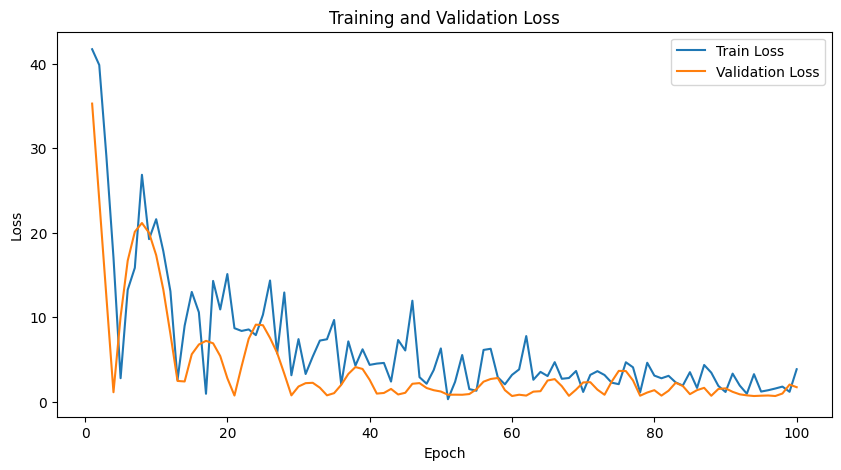

In [8]:
import matplotlib.pyplot as plt
import pandas as pd


df = pd.read_csv("..\\artifacts\\Qwen\\Qwen2-VL-2B-Instruct_Test_run\\training_log.csv")
# Separate train and validation data
train_df = df[df["split"] == "train_epoch"]
val_df = df[df["split"] == "val_epoch"]

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_df["epoch"], train_df["loss"], label="Train Loss")
plt.plot(val_df["epoch"], val_df["loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()
